In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import jsonpickle

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
RUNDIR = "../output"
RUNID = "20240201_001801"

In [4]:
config_files = list(Path(RUNDIR).glob(f"{RUNID}*.config.json"))
print(f"Found {len(config_files)} config files")

Found 3 config files


In [22]:
configs = {}
dfs = {}
for config_file in config_files:
    config = jsonpickle.decode(config_file.read_text())
    data_file = Path(RUNDIR, config_file.name.split(".")[0] + ".csv")
    sub_id = config_file.name.split(".")[0].split("_")[-1]
    
    data = pd.read_csv(data_file)
    data["id"] = sub_id
    data["algorithm"] = config["algorithm"]
    data["dataset"] = config["dataset"]
    data["imbalance"] = config["imbalance_type"]
    data["imbalance_val"] = config["imbalance_value"]
    data["is_last_round"] = data["round"] == (config["rounds"] - 1)
    
    if sub_id in configs:
        print("Duplicate id!")
    dfs[sub_id] = data
    configs[sub_id] = config
    
data = pd.concat(dfs.values(), axis=0)

In [23]:
data = data.pivot_table(values = "value", index = ["round", "client", "stage", "id", "algorithm", "dataset", "imbalance", "imbalance_val", "is_last_round"], columns = ["variable"]).reset_index()
data.head()

variable,round,client,stage,id,algorithm,dataset,imbalance,imbalance_val,is_last_round,f1,loss,n_samples
0,0,0,test,0,local,cifar10,label_distribution,1.0,False,0.342634,0.025079,840.0
1,0,0,test,1,local,cifar10,label_distribution,10.0,False,0.106486,0.037552,598.0
2,0,0,test,2,local,cifar10,label_distribution,0.1,False,0.251559,0.056458,78.0
3,0,0,train,0,local,cifar10,label_distribution,1.0,False,NaN,1.725846,840.0
4,0,0,train,1,local,cifar10,label_distribution,10.0,False,NaN,2.281217,598.0


<Axes: xlabel='round', ylabel='loss'>

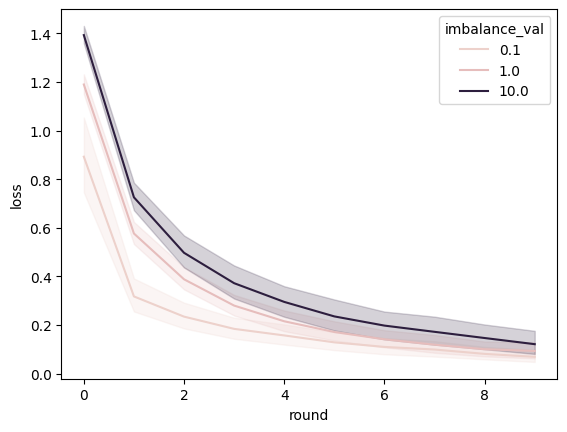

In [24]:
df = data.query("stage == 'train'")
sns.lineplot(df, x = "round", y = "loss", hue = "imbalance_val")

<Axes: xlabel='round', ylabel='f1'>

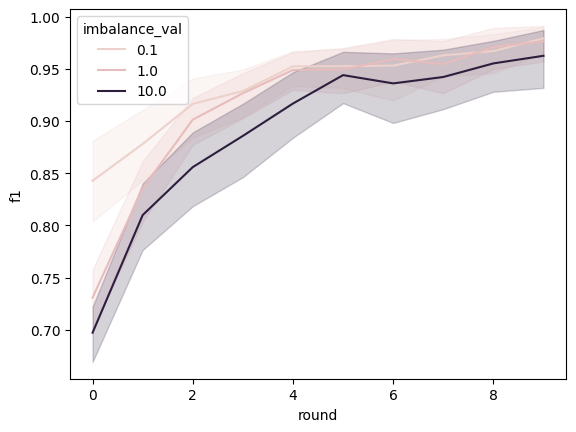

In [25]:
df = data.query("stage == 'test'")
sns.lineplot(df, x = "round", y = "f1", hue = "imbalance_val")

In [26]:
df_last = data.query("stage == 'test' and is_last_round")
df_last.head()

variable,round,client,stage,id,algorithm,dataset,imbalance,imbalance_val,is_last_round,f1,loss,n_samples
4320,9,0,test,0,local,cifar10,label_distribution,1.0,True,0.611524,0.017019,840.0
4321,9,0,test,1,local,cifar10,label_distribution,10.0,True,0.431011,0.025028,598.0
4322,9,0,test,2,local,cifar10,label_distribution,0.1,True,0.607930,0.024184,78.0
4326,9,1,test,0,local,cifar10,label_distribution,1.0,True,0.762195,0.010540,714.0
4327,9,1,test,1,local,cifar10,label_distribution,10.0,True,0.639119,0.018197,661.0


Text(0.5, 1.0, 'Avg. F1 scores by imbalance param')

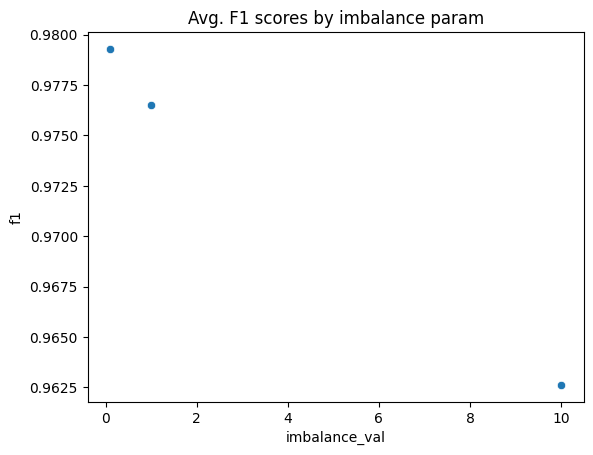

In [41]:
df_last_avg = df_last.groupby(["imbalance", "imbalance_val"]).mean(["f1", "loss"]).reset_index()
sns.scatterplot(df_last_avg, x="imbalance_val", y="f1")
plt.title("Avg. F1 scores by imbalance param")